[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/14CPjrMTnKB7T6a50A7FzhDpPWDJe3ZPq?usp=sharing)

In [4]:
# Import libraries
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.cluster.hierarchy import dendrogram
from matplotlib import cm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold, mutual_info_regression, chi2, f_classif
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, silhouette_samples
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.utils import resample
from joblib import Parallel, delayed
import warnings
import time

# Pengumpulan & pembersihan data

In [5]:
# Download dataset
file_id = '1oEXSD137hPm_Fx5xSPRvlAr3silj3suK'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
gdown.download(url, 'dataset.csv', quiet=False)

# Load data with error handling
try:
    df = pd.read_csv('dataset.csv', encoding='latin1')
except Exception as e:
    print(f"Error loading file: {e}")
    # Try alternative encodings if needed
    try:
        df = pd.read_csv('dataset.csv', encoding='ISO-8859-1')
    except:
        df = pd.read_csv('dataset.csv', encoding='utf-8', errors='ignore')

# Enhanced data inspection
def inspect_data(df):
    print("=== DATA INSPECTION ===")
    print(f"Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes.value_counts())

    print("\nMissing Values Summary:")
    missing = df.isnull().sum()
    print(missing[missing > 0])

    print("\nDuplicate Rows:", df.duplicated().sum())

    numeric_cols = df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        print("\nNumeric Columns Statistics:")
        print(df[numeric_cols].describe().T)

    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    if len(cat_cols) > 0:
        print("\nCategorical Columns Summary:")
        for col in cat_cols:
            print(f"\n{col}:")
            print(df[col].value_counts(dropna=False).head())

inspect_data(df)

# Advanced cleaning function
def clean_data(df, outlier_threshold=1.5):
    # Make a copy
    clean_df = df.copy()

    # Handle missing values
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')

    numeric_cols = clean_df.select_dtypes(include=np.number).columns
    if len(numeric_cols) > 0:
        clean_df[numeric_cols] = num_imputer.fit_transform(clean_df[numeric_cols])

    cat_cols = clean_df.select_dtypes(include=['object']).columns
    if len(cat_cols) > 0:
        clean_df[cat_cols] = cat_imputer.fit_transform(clean_df[cat_cols])

    # Handle outliers using IQR method
    for col in numeric_cols:
        q1 = clean_df[col].quantile(0.25)
        q3 = clean_df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - outlier_threshold * iqr
        upper = q3 + outlier_threshold * iqr
        clean_df[col] = np.where(clean_df[col] < lower, lower,
                                np.where(clean_df[col] > upper, upper, clean_df[col]))

    # Remove duplicates
    clean_df = clean_df.drop_duplicates()

    # Convert object types to category for memory efficiency
    for col in cat_cols:
        clean_df[col] = clean_df[col].astype('category')

    return clean_df

cleaned_df = clean_data(df)
print("\nData cleaning completed. New shape:", cleaned_df.shape)


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK
From (redirected): https://drive.google.com/uc?export=download&id=1oEXSD137hPm_Fx5xSPRvlAr3silj3suK&confirm=t&uuid=9dc82436-5b49-49c8-9aa2-dc77b5a6c749
To: /content/dataset.csv
100%|██████████| 443M/443M [00:08<00:00, 51.2MB/s]


=== DATA INSPECTION ===
Shape: (515344, 91)

Data Types:
float64    90
int64       1
Name: count, dtype: int64

Missing Values Summary:
Series([], dtype: int64)

Duplicate Rows: 214

Numeric Columns Statistics:
              count         mean         std         min          25%  \
2001       515344.0  1998.397077   10.931056  1922.00000  1994.000000   
49.94357   515344.0    43.387113    6.067557     1.74900    39.954667   
21.47114   515344.0     1.289515   51.580393  -337.09250   -26.059848   
73.0775    515344.0     8.658222   35.268505  -301.00506   -11.462775   
8.74861    515344.0     1.164110   16.322802  -154.18358    -8.487507   
...             ...          ...         ...         ...          ...   
-23.08793  515344.0    17.669292  114.428002 -3168.92457   -31.580617   
68.40795   515344.0   -26.315520  173.977455 -4319.99232  -101.530305   
-1.82223   515344.0     4.458653   13.346567  -236.03926    -2.566137   
-27.46348  515344.0    20.035229  185.558415 -7458.37815   

In [3]:
print(cleaned_df.columns)

Index(['2001', '49.94357', '21.47114', '73.0775', '8.74861', '-17.40628',
       '-13.09905', '-25.01202', '-12.23257', '7.83089', '-2.46783', '3.32136',
       '-2.31521', '10.20556', '611.10913', '951.0896', '698.11428',
       '408.98485', '383.70912', '326.51512', '238.11327', '251.42414',
       '187.17351', '100.42652', '179.19498', '-8.41558', '-317.87038',
       '95.86266', '48.10259', '-95.66303', '-18.06215', '1.96984', '34.42438',
       '11.7267', '1.3679', '7.79444', '-0.36994', '-133.67852', '-83.26165',
       '-37.29765', '73.04667', '-37.36684', '-3.13853', '-24.21531',
       '-13.23066', '15.93809', '-18.60478', '82.15479', '240.5798',
       '-10.29407', '31.58431', '-25.38187', '-3.90772', '13.29258', '41.5506',
       '-7.26272', '-21.00863', '105.50848', '64.29856', '26.08481',
       '-44.5911', '-8.30657', '7.93706', '-10.7366', '-95.44766', '-82.03307',
       '-35.59194', '4.69525', '70.95626', '28.09139', '6.02015', '-37.13767',
       '-41.1245', '-8.40816

# Feature selection

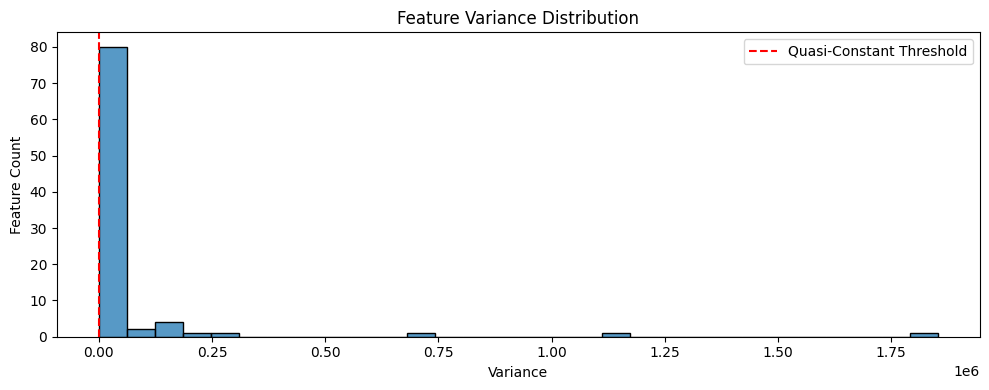

Duplicate Features Found: [] ...


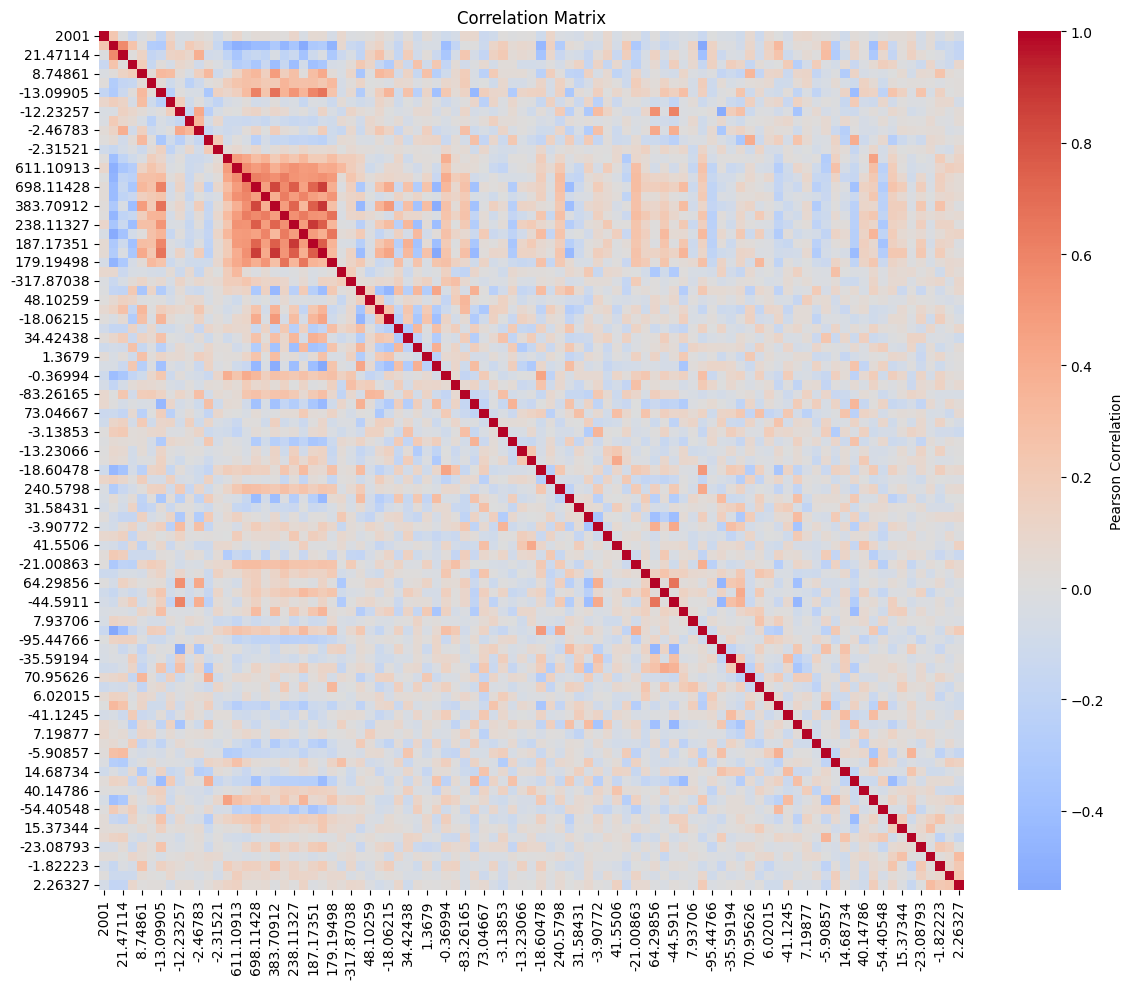

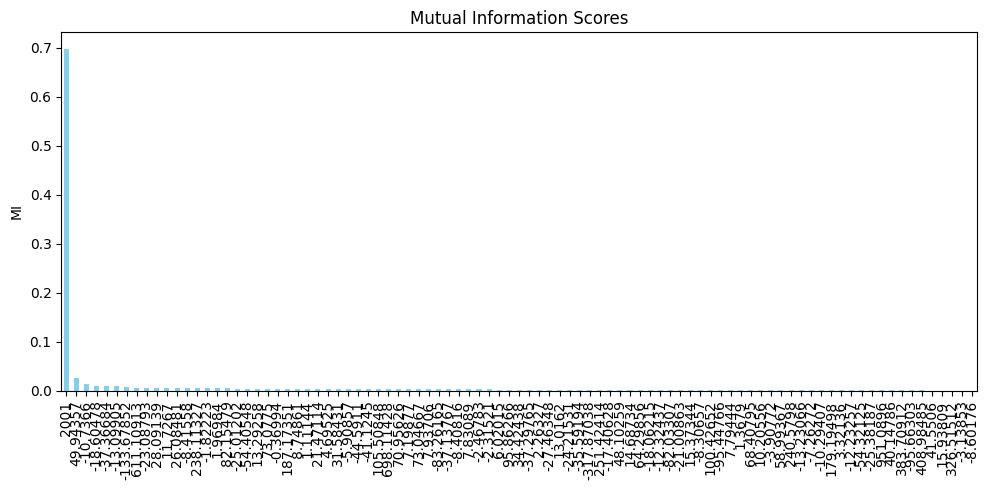

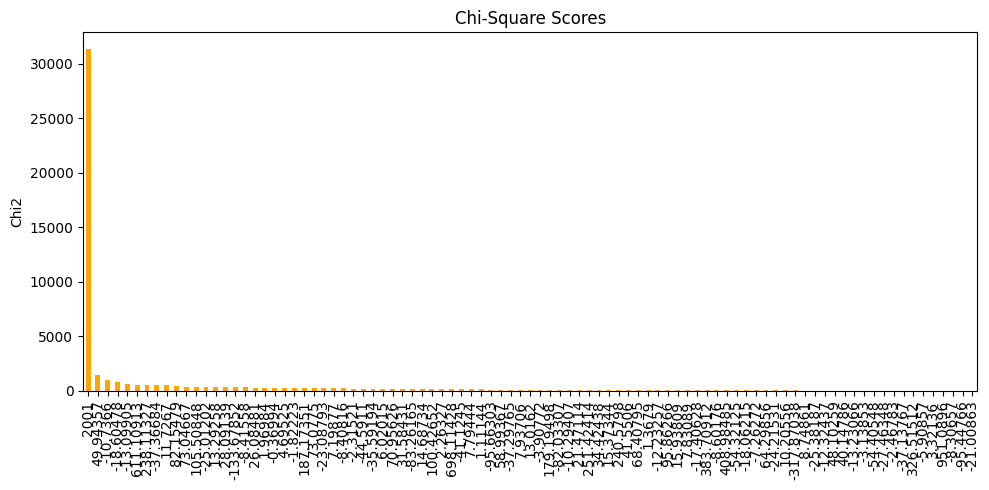

<ipython-input-31-f14778f71f07>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=anova_df['F-Value'], y=anova_df.index, palette='magma')


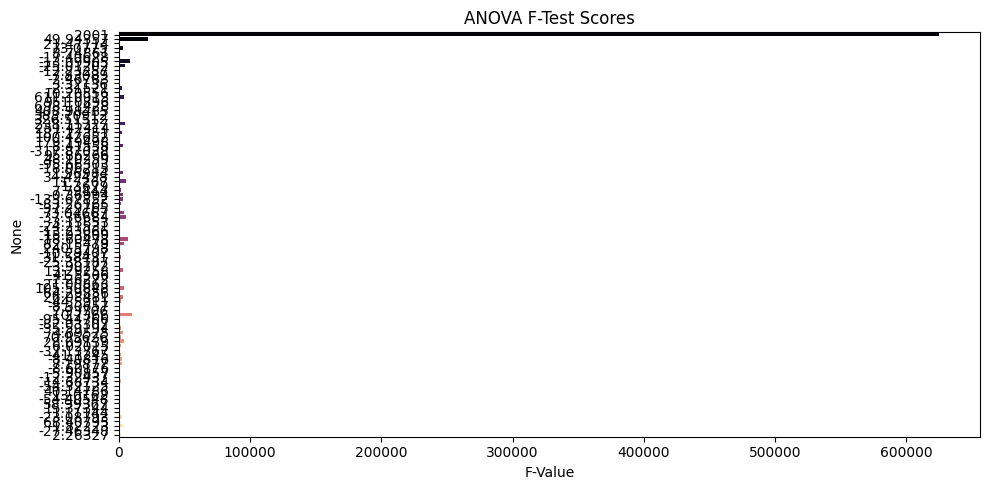

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, f_classif, chi2
from sklearn.preprocessing import KBinsDiscretizer, LabelEncoder, MinMaxScaler
from scipy.stats import f_oneway

# Asumsikan df sudah dibersihkan dan dimuat -> cleaned_df
df = cleaned_df.copy()

# Optional: Tentukan target kolom untuk supervised methods
# Misalnya pakai kolom '2001' -> binarized
target_col = '2001'
df['target'] = (df[target_col] > df[target_col].median()).astype(int)

# Pisahkan fitur dan target
X = df.drop(columns=['target'])
y = df['target']

# --- 1. Constant & Quasi-Constant Features ---
variances = X.var()
quasi_constant = variances[variances < 0.01].index.tolist()

plt.figure(figsize=(10, 4))
sns.histplot(variances, bins=30, kde=False)
plt.title("Feature Variance Distribution")
plt.xlabel("Variance")
plt.ylabel("Feature Count")
plt.axvline(0.01, color='red', linestyle='--', label='Quasi-Constant Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# --- 2. Duplicate Features ---
duplicates = []
cols = X.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if X[cols[i]].equals(X[cols[j]]):
            duplicates.append((cols[i], cols[j]))

print(f"Duplicate Features Found: {duplicates[:5]} ...")

# --- 3. Correlation Matrix ---
corr = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', center=0, cbar_kws={'label': 'Pearson Correlation'})
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# --- 4. Mutual Information ---
mi = mutual_info_classif(X, y, random_state=42)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
mi_series.plot(kind='bar', color='skyblue')
plt.title("Mutual Information Scores")
plt.ylabel("MI")
plt.tight_layout()
plt.show()

# --- 5. Chi-Square Test ---
# Fitur harus non-negatif
X_chi = MinMaxScaler().fit_transform(X)
chi_scores, _ = chi2(X_chi, y)

chi_series = pd.Series(chi_scores, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
chi_series.plot(kind='bar', color='orange')
plt.title("Chi-Square Scores")
plt.ylabel("Chi2")
plt.tight_layout()
plt.show()

# --- 6. ANOVA F-test ---
f_values, p_values = f_classif(X, y)
anova_df = pd.DataFrame({'F-Value': f_values, 'p-Value': p_values}, index=X.columns)

plt.figure(figsize=(10, 5))
sns.barplot(x=anova_df['F-Value'], y=anova_df.index, palette='magma')
plt.title("ANOVA F-Test Scores")
plt.xlabel("F-Value")
plt.tight_layout()
plt.show()


# Feature engginering

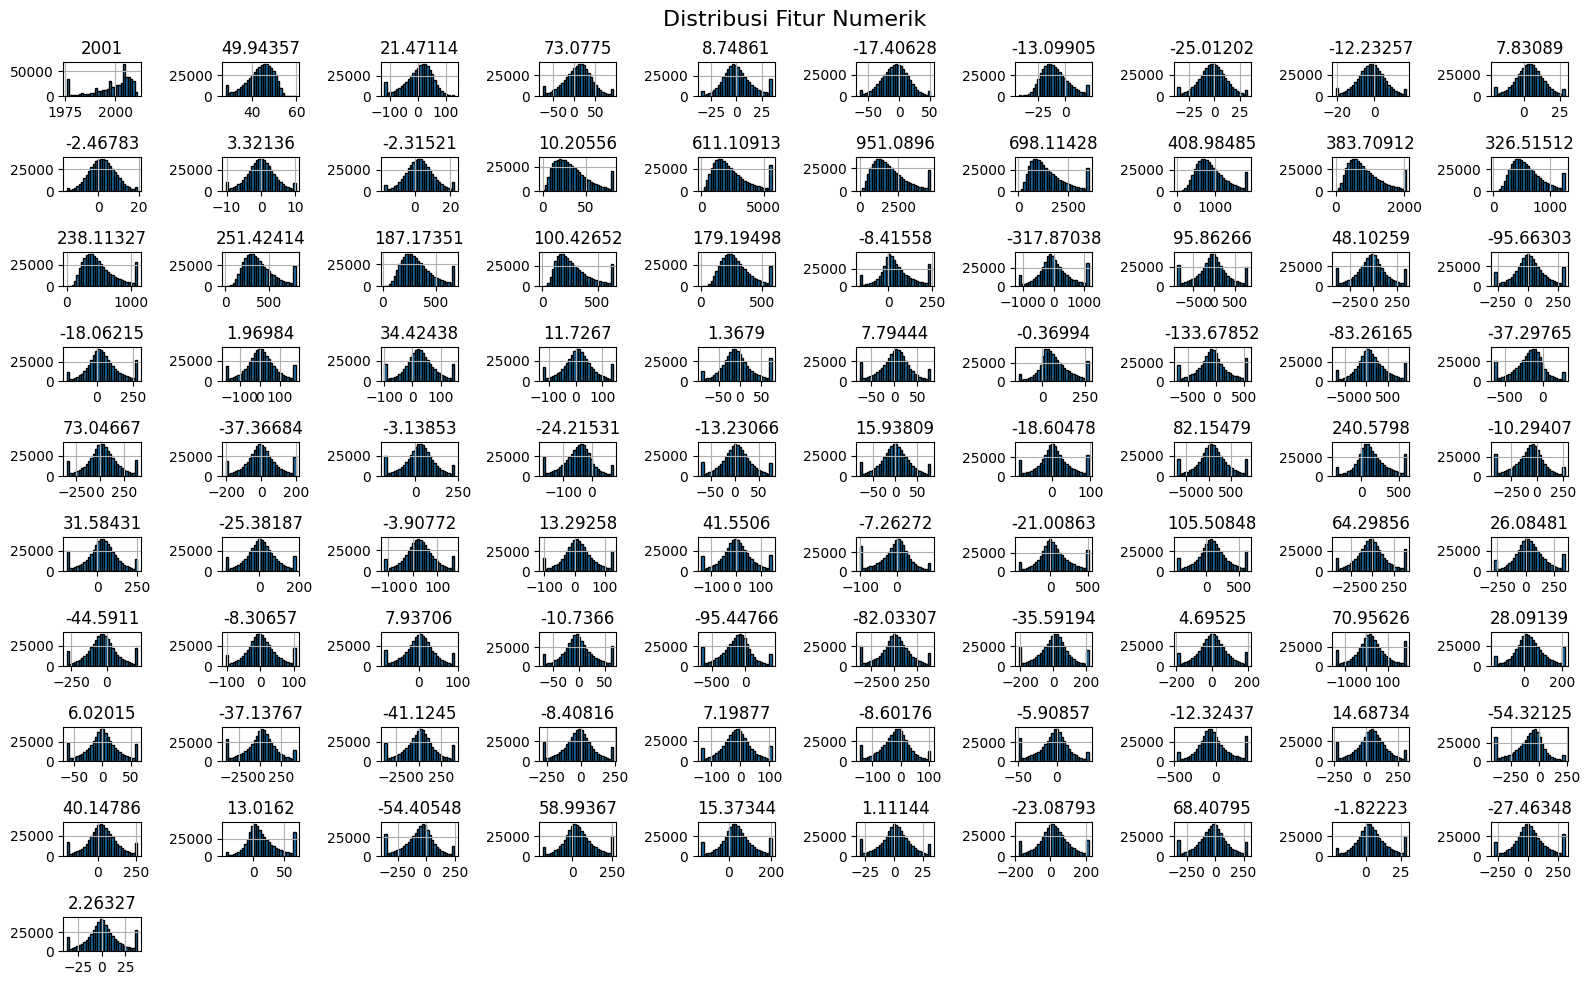

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numeric_distributions(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    df[numeric_cols].hist(figsize=(16, 10), bins=30, edgecolor='black')
    plt.suptitle('Distribusi Fitur Numerik', fontsize=16)
    plt.tight_layout()
    plt.show()

plot_numeric_distributions(cleaned_df)


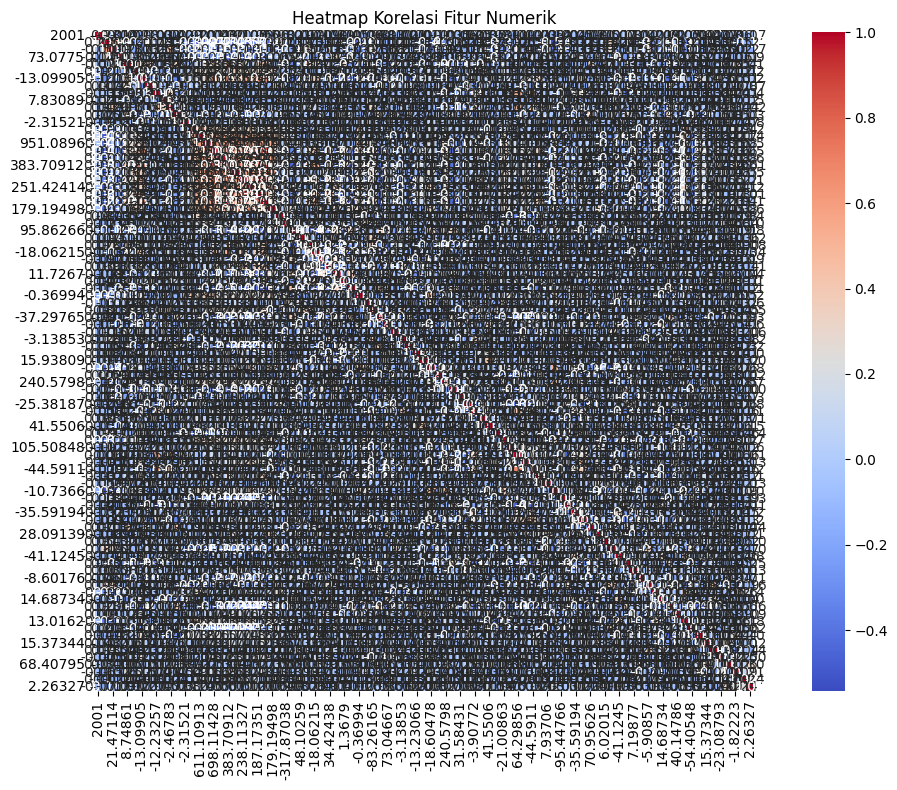

In [29]:
def plot_correlation_heatmap(df):
    numeric_df = df.select_dtypes(include=np.number)
    plt.figure(figsize=(12, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title('Heatmap Korelasi Fitur Numerik')
    plt.tight_layout()
    plt.show()

plot_correlation_heatmap(cleaned_df)


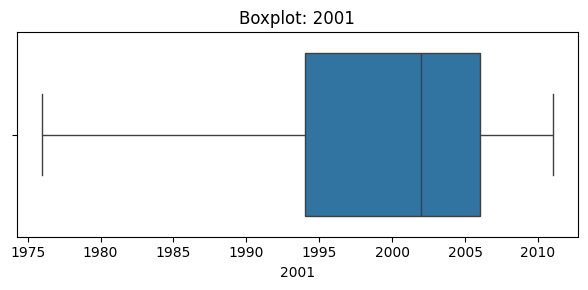

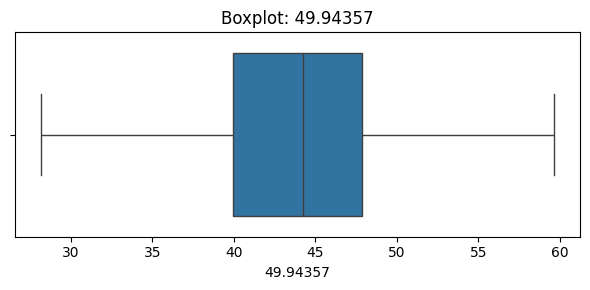

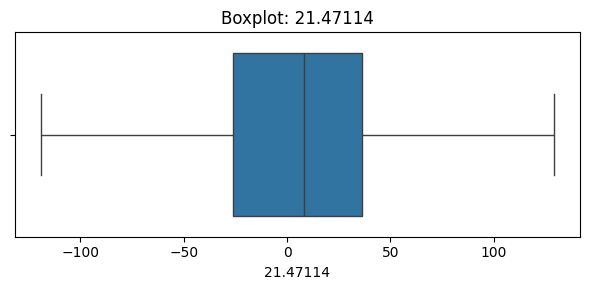

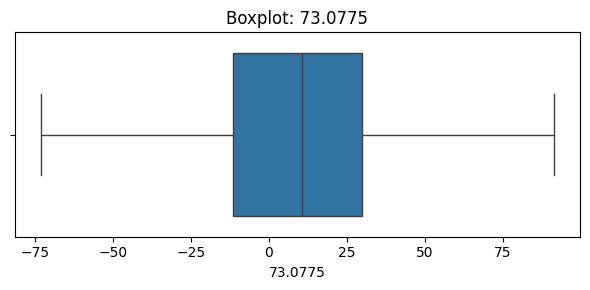

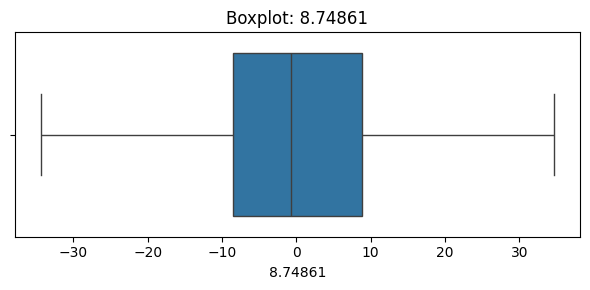

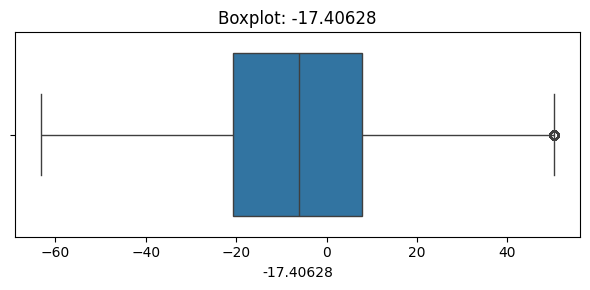

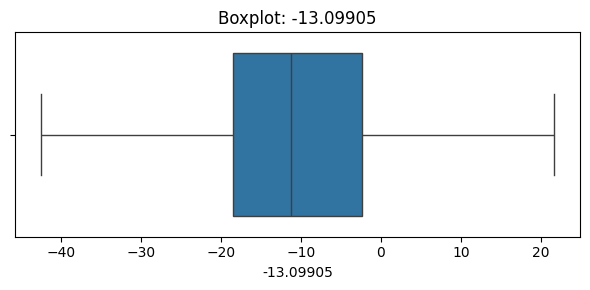

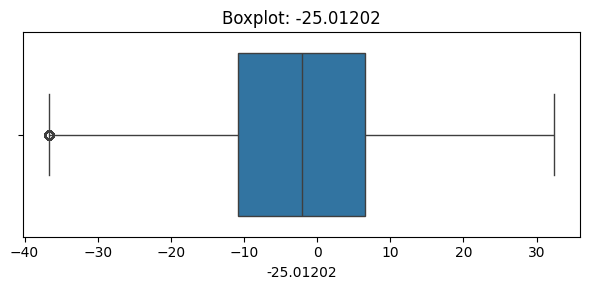

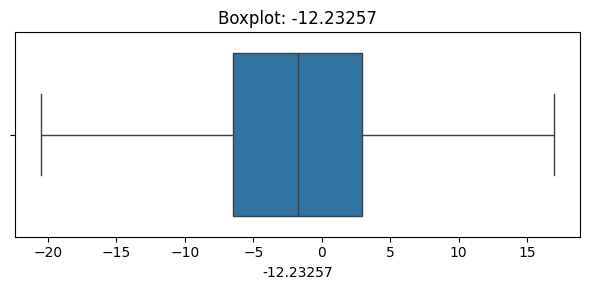

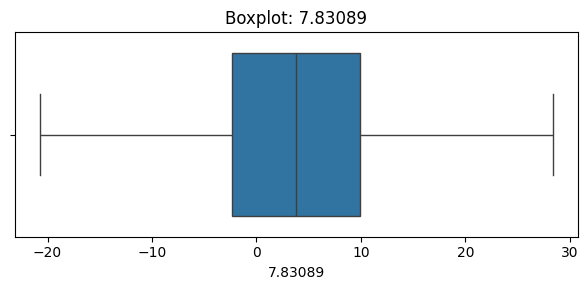

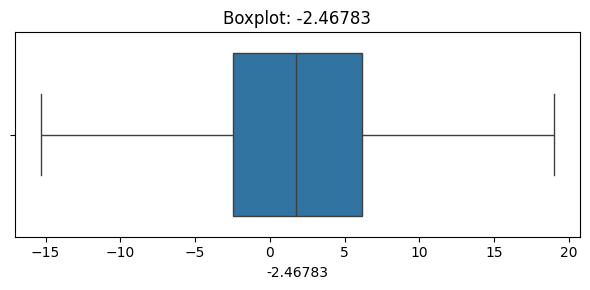

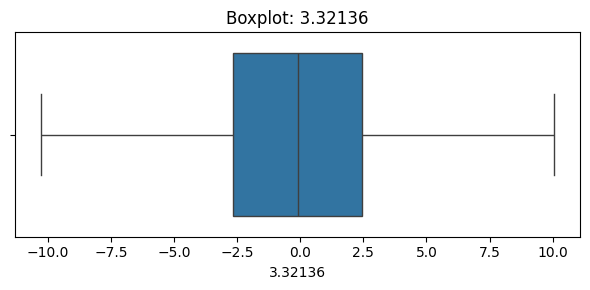

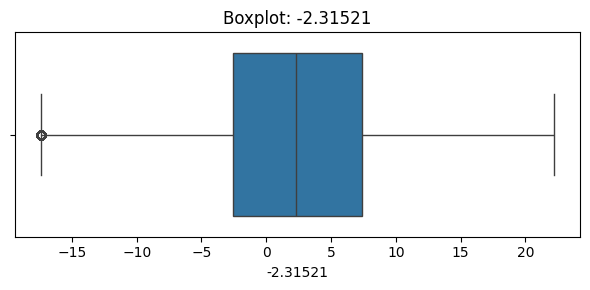

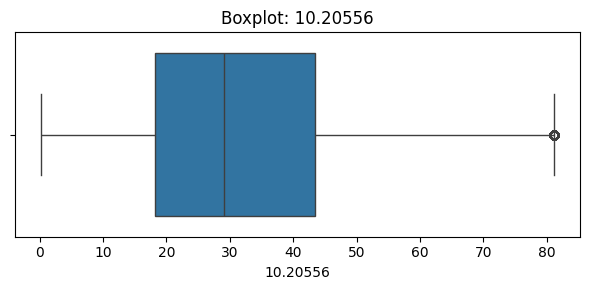

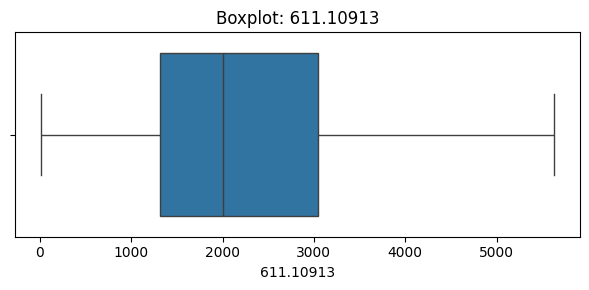

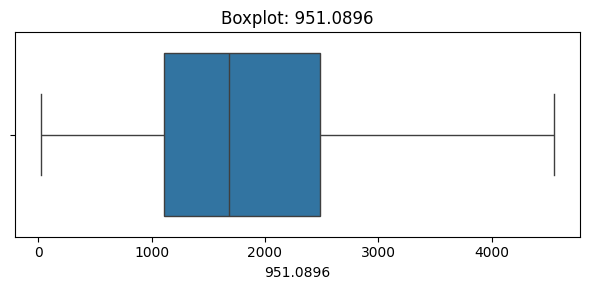

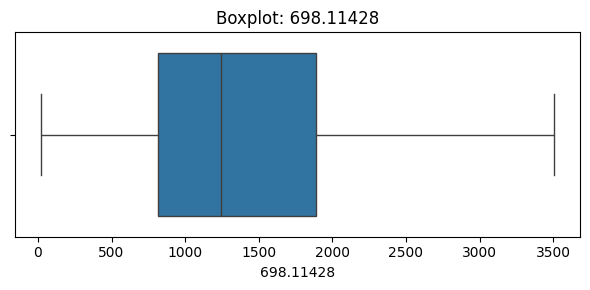

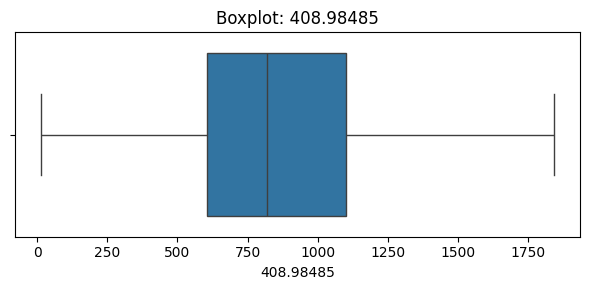

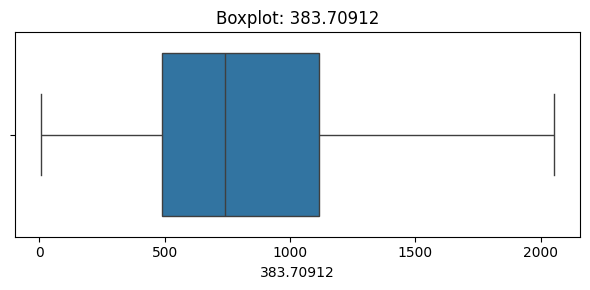

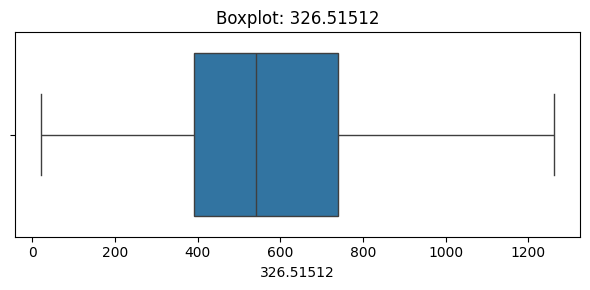

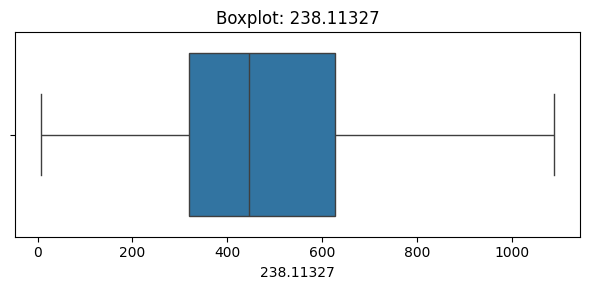

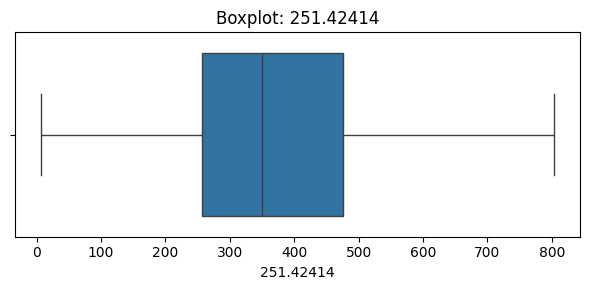

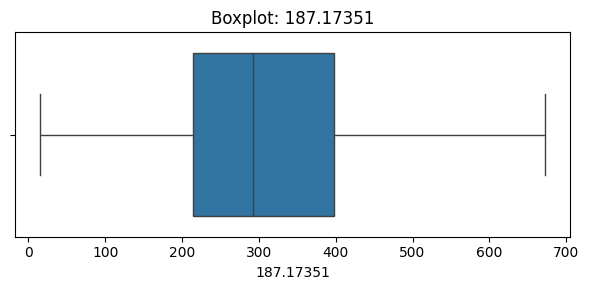

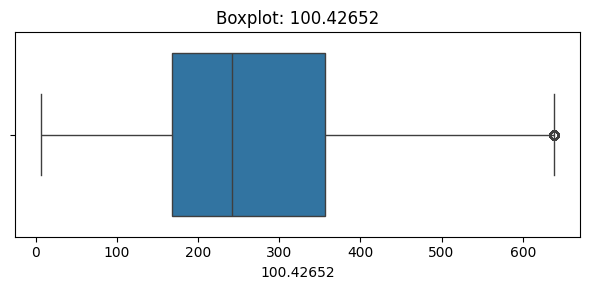

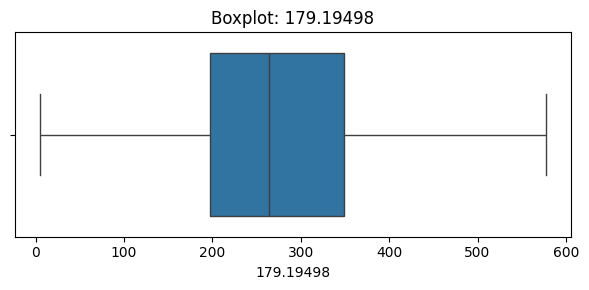

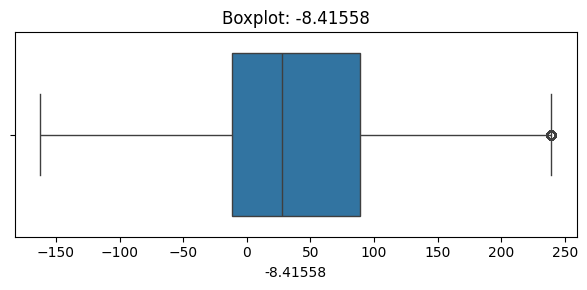

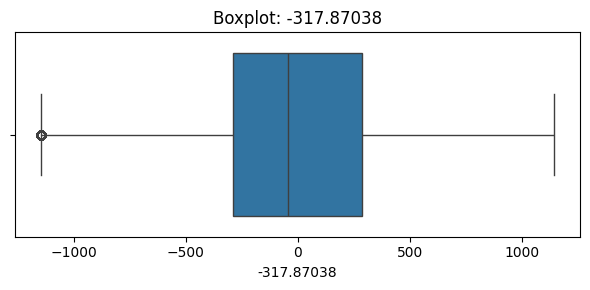

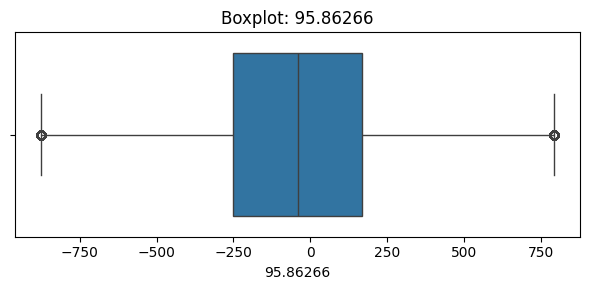

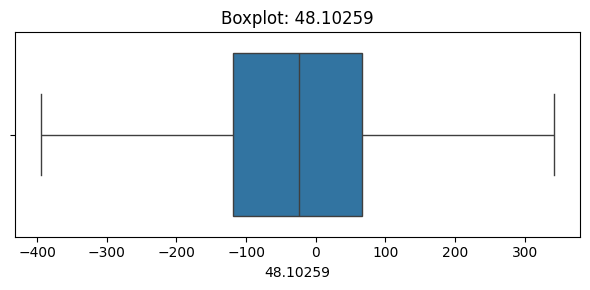

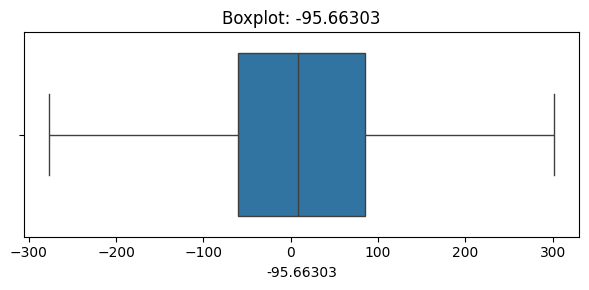

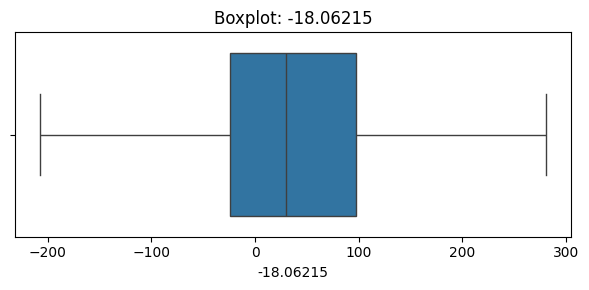

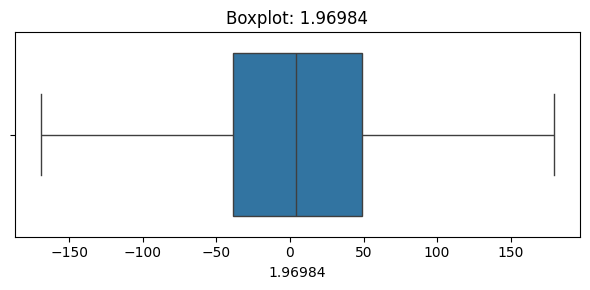

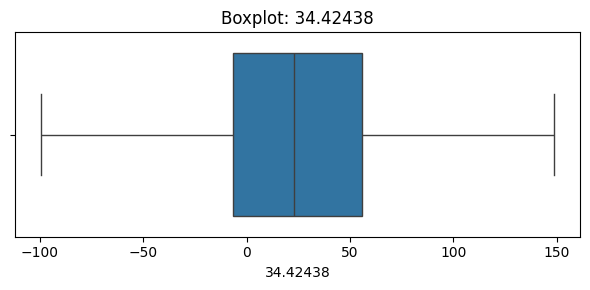

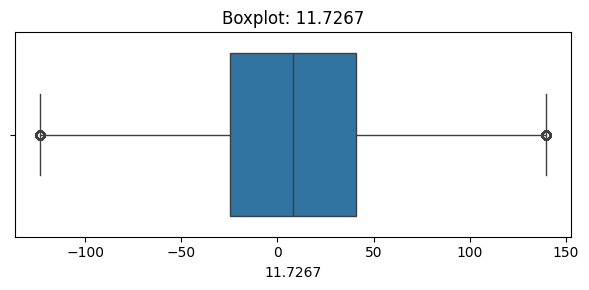

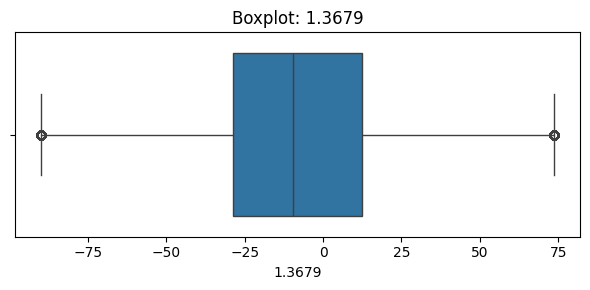

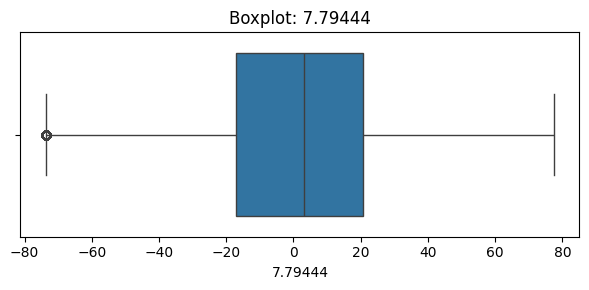

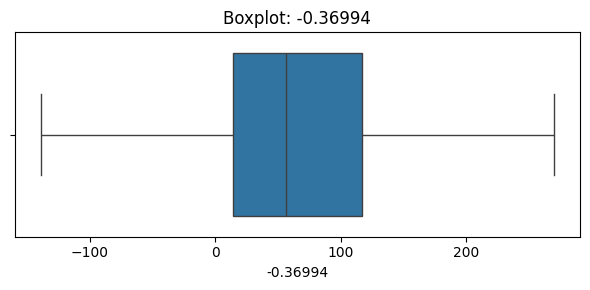

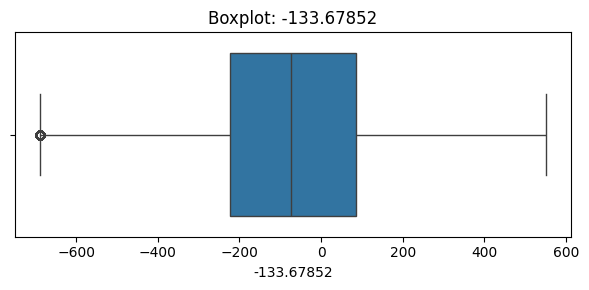

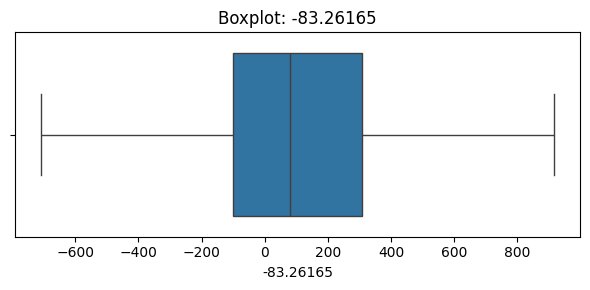

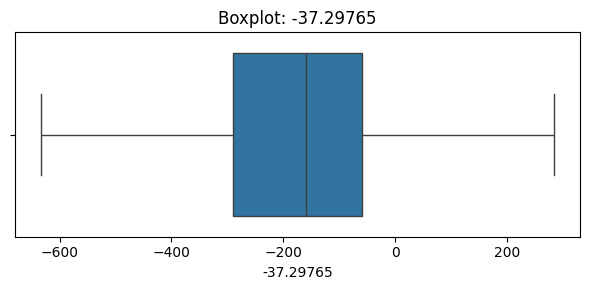

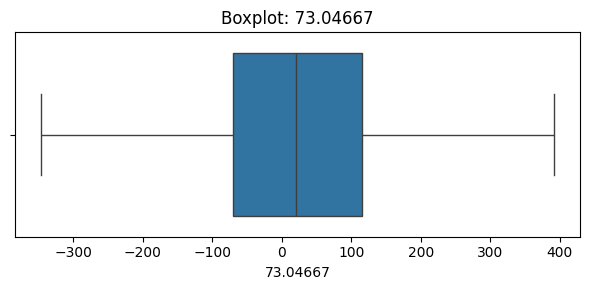

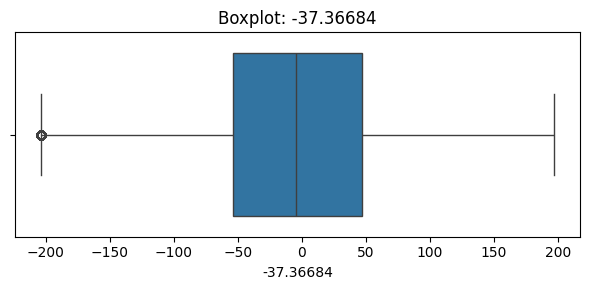

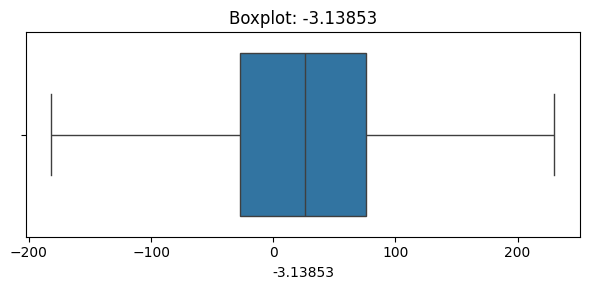

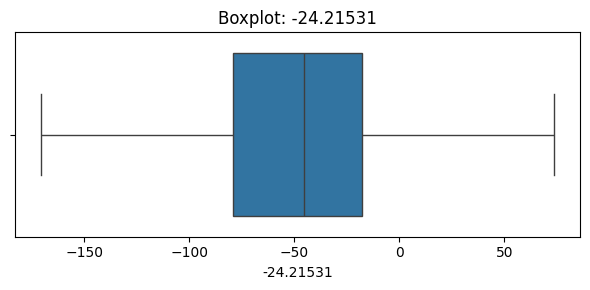

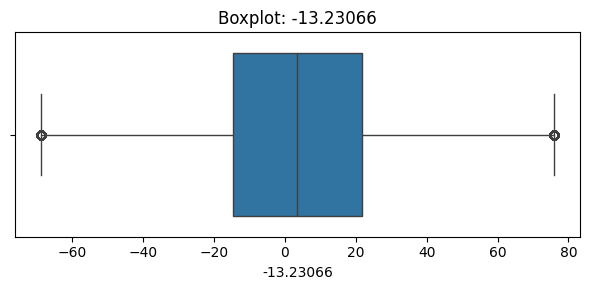

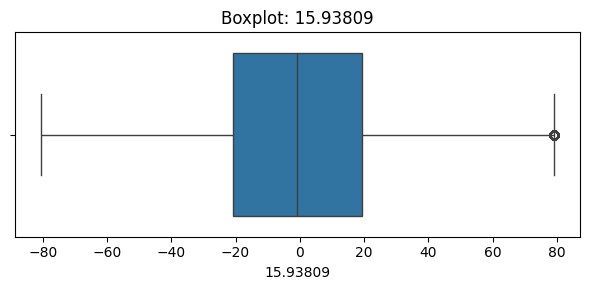

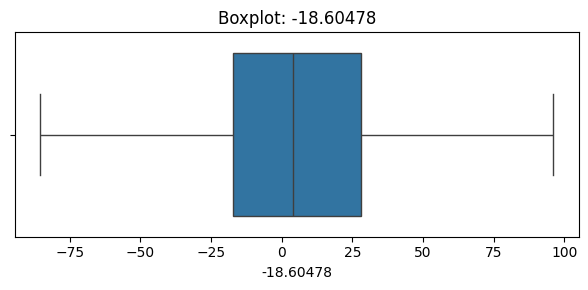

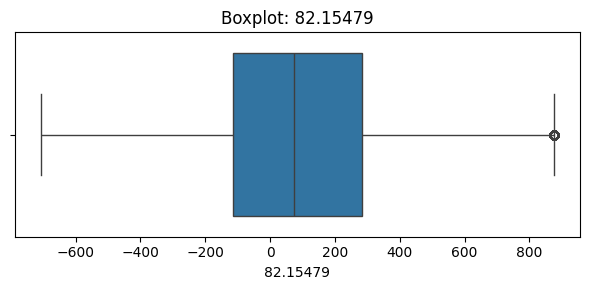

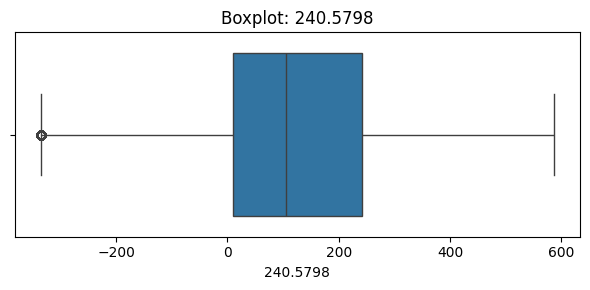

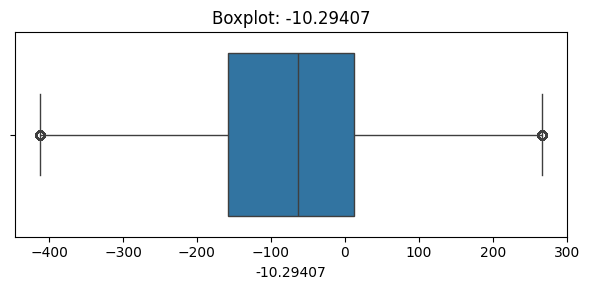

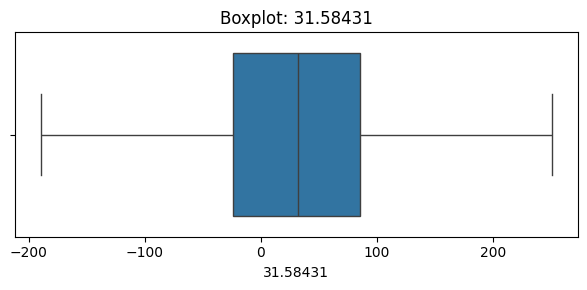

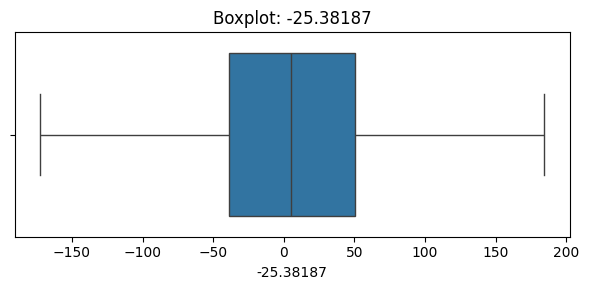

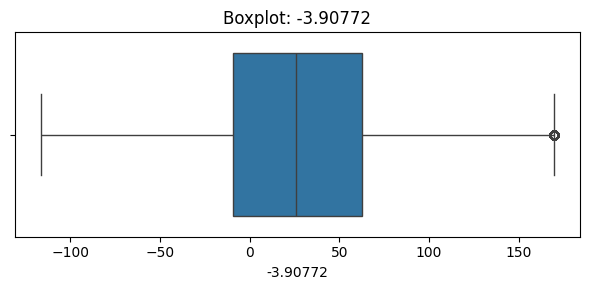

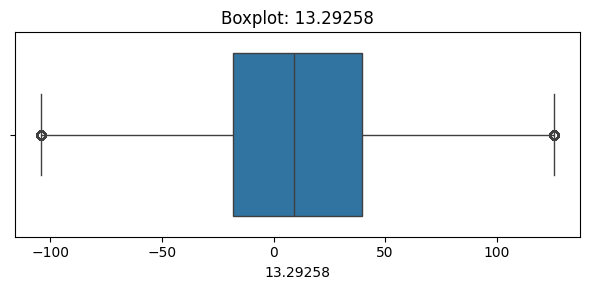

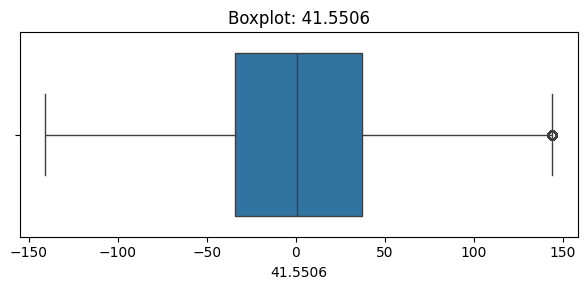

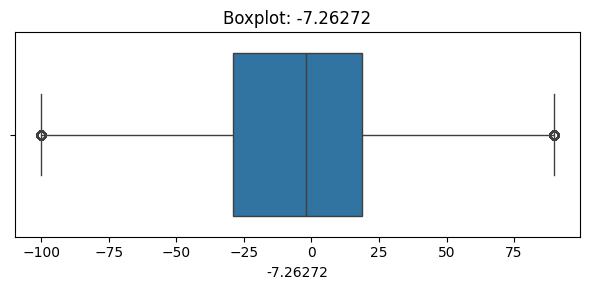

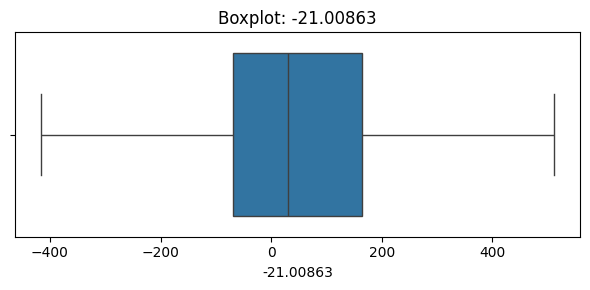

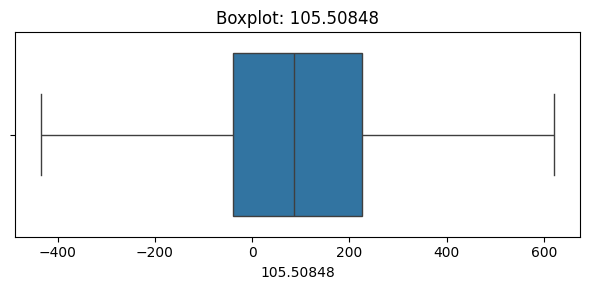

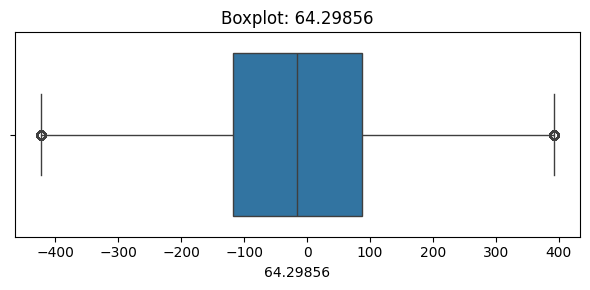

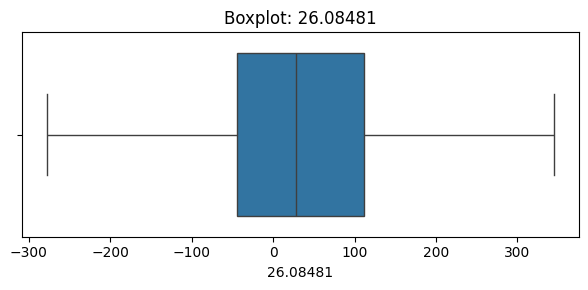

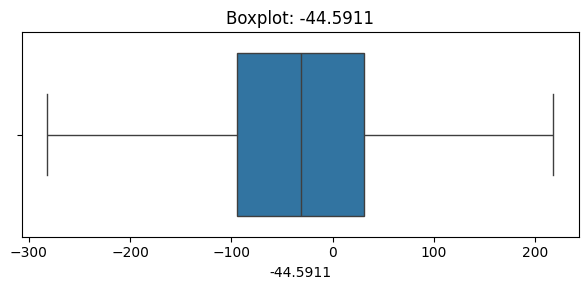

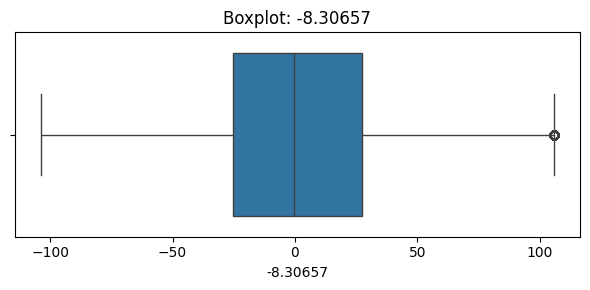

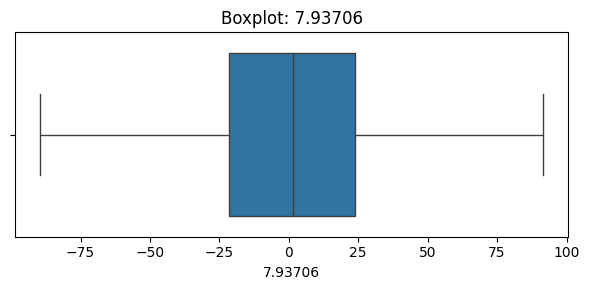

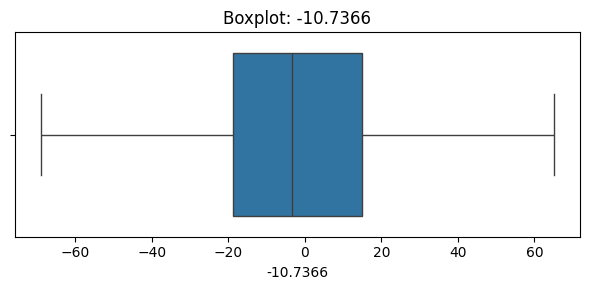

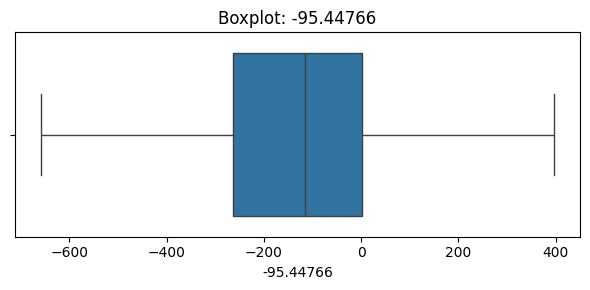

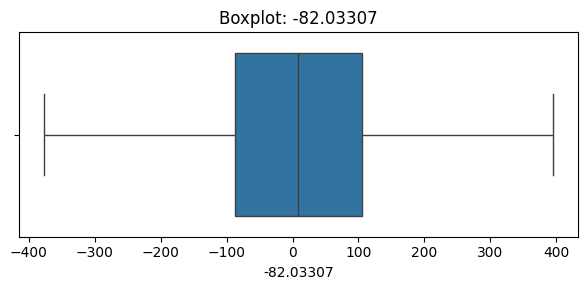

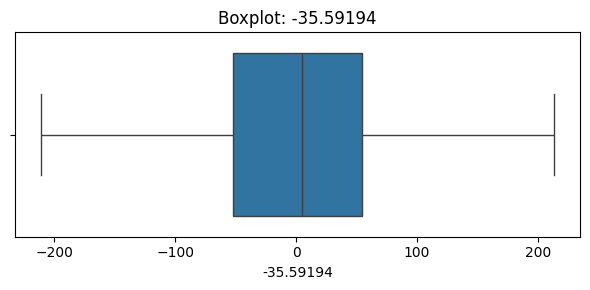

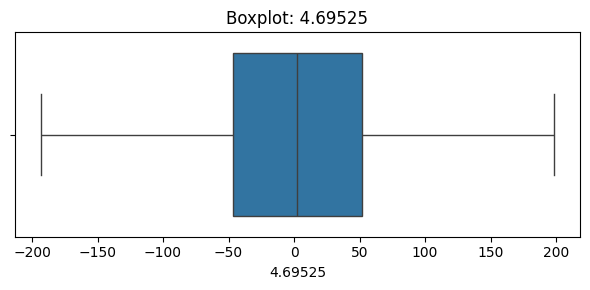

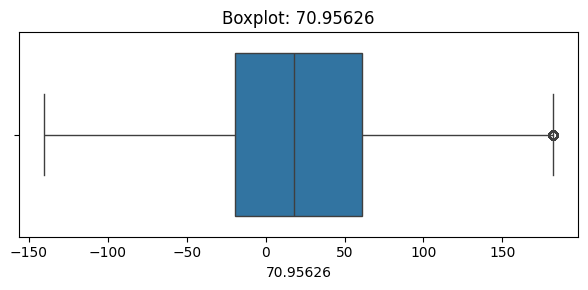

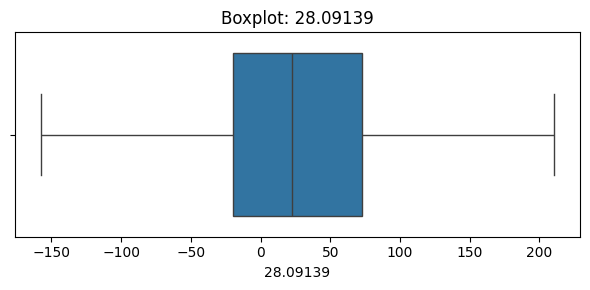

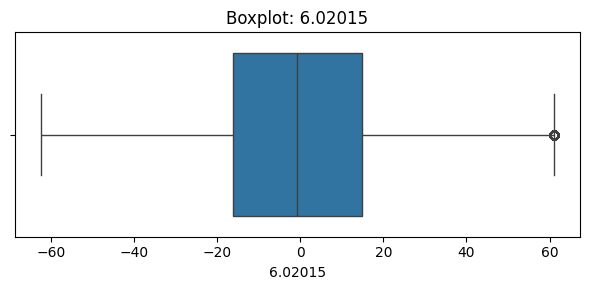

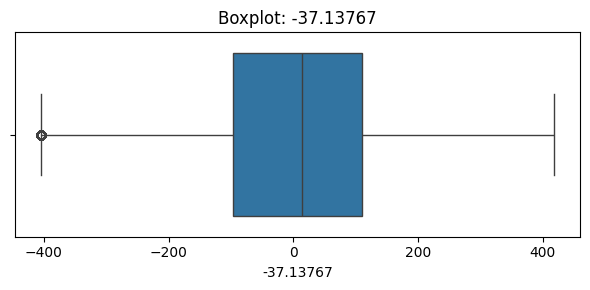

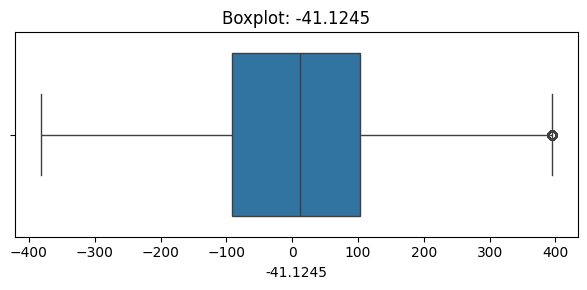

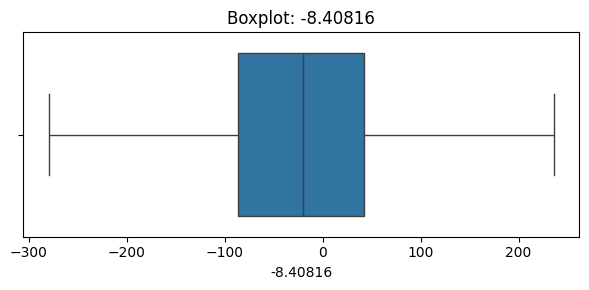

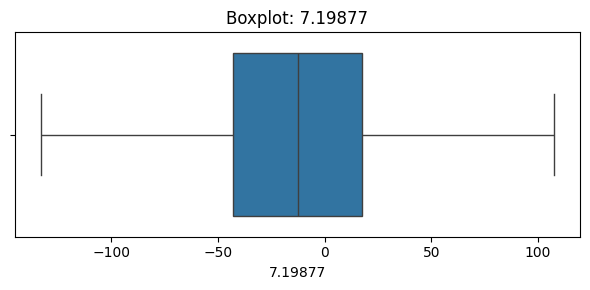

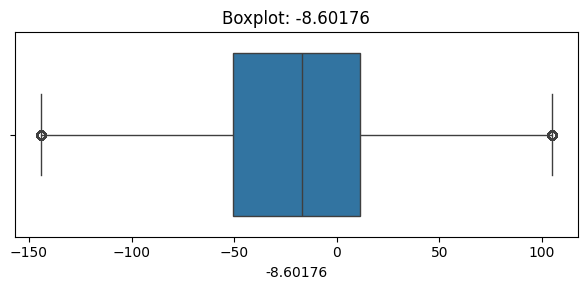

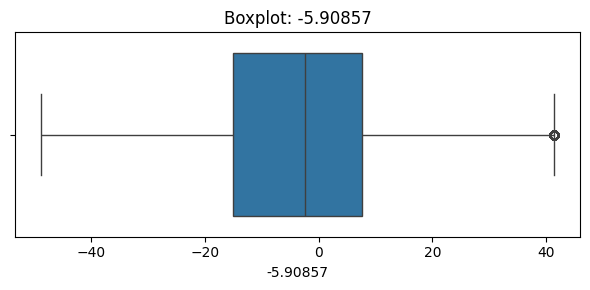

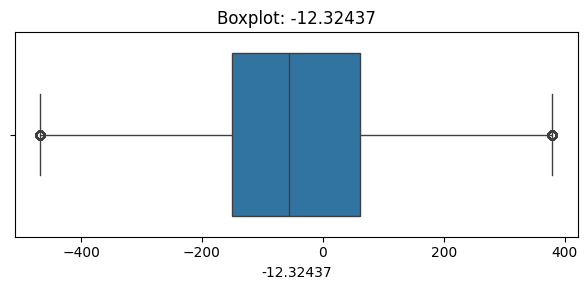

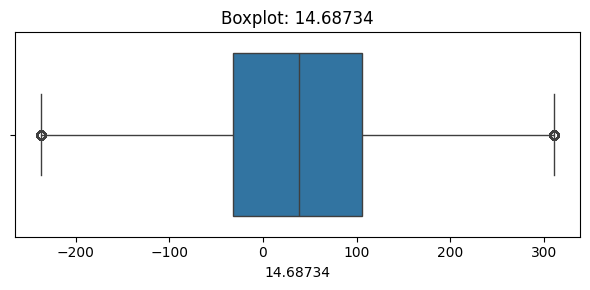

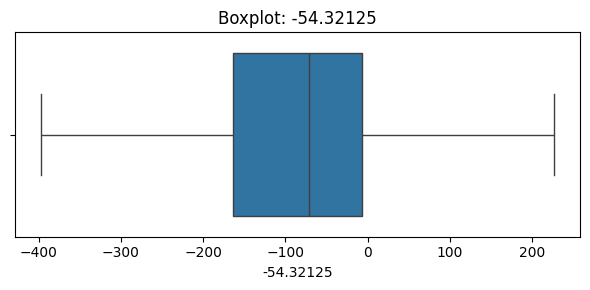

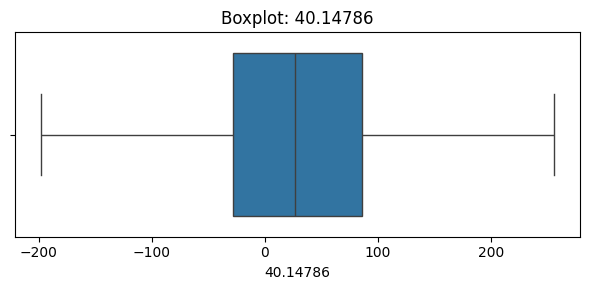

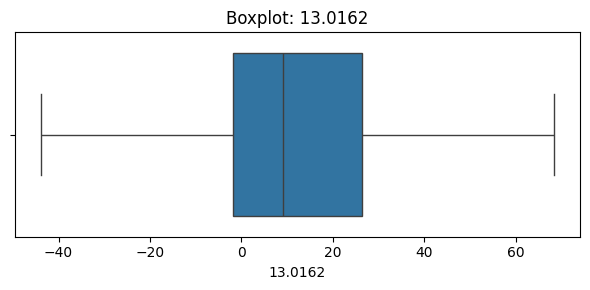

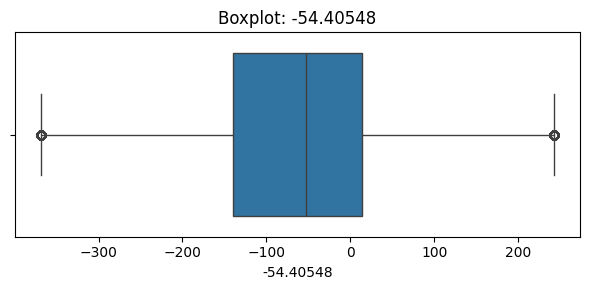

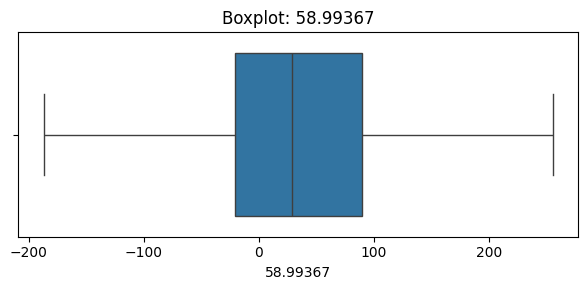

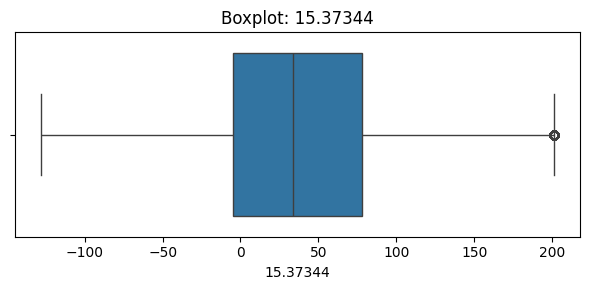

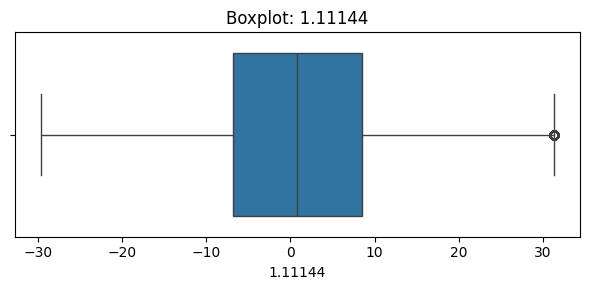

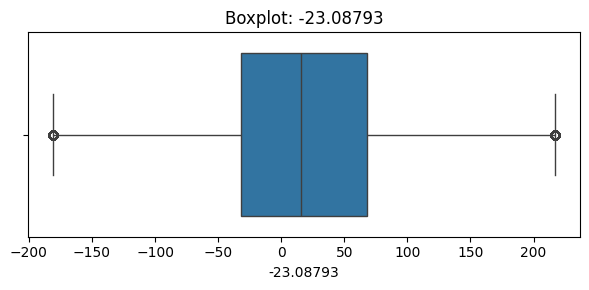

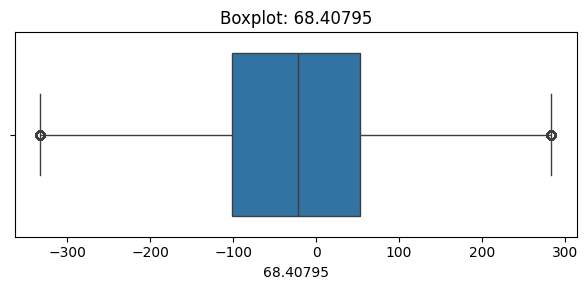

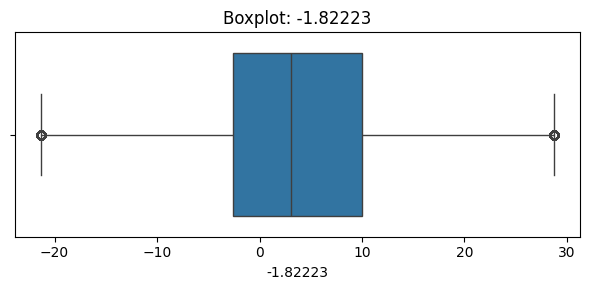

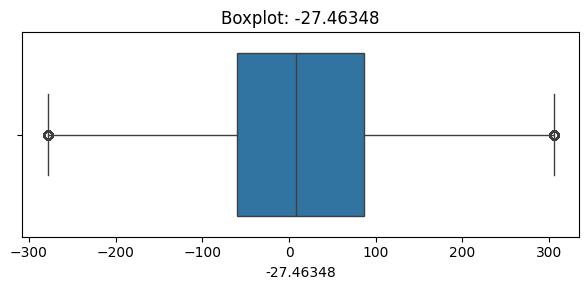

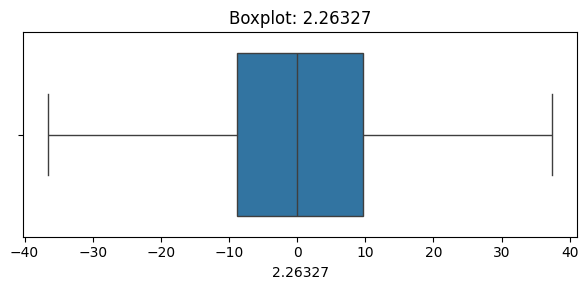

In [32]:
def plot_categorical_counts(df):
    cat_cols = df.select_dtypes(include='category').columns
    for col in cat_cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col)
        plt.title(f'Frekuensi Kategori: {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

plot_categorical_counts(cleaned_df)

def plot_boxplots(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        plt.figure(figsize=(6, 3))
        sns.boxplot(data=df, x=col)
        plt.title(f'Boxplot: {col}')
        plt.tight_layout()
        plt.show()

plot_boxplots(cleaned_df)


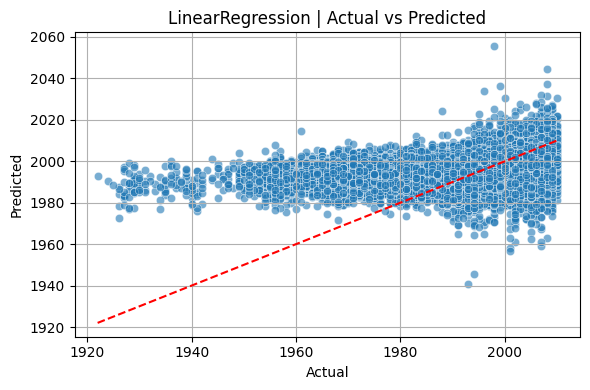

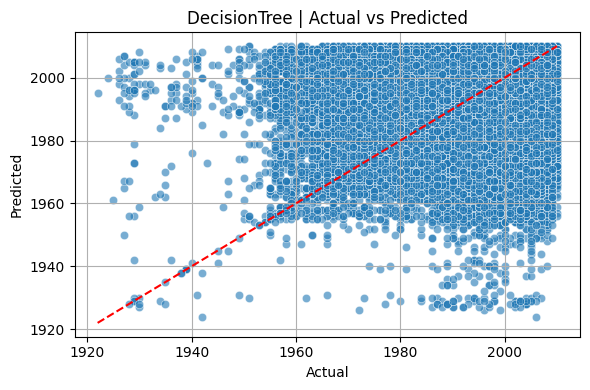

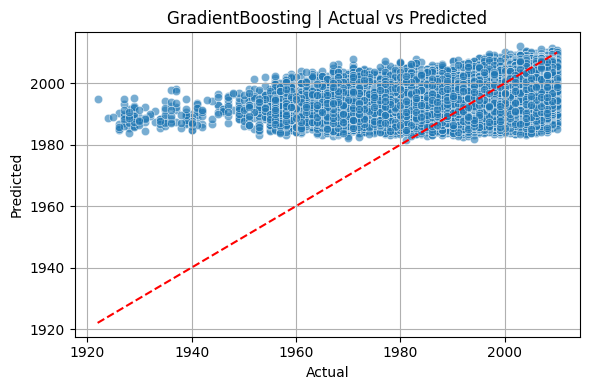

              Model         MSE       RMSE       R^2
2  GradientBoosting   86.593425   9.305559  0.270408
0  LinearRegression   90.683006   9.522763  0.235951
1      DecisionTree  176.613104  13.289586 -0.488052


In [8]:
# IMPORT MODUL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# LOAD DATA (ganti sesuai kebutuhan)
df = pd.read_csv('dataset.csv', encoding='latin1')

# KONVERSI KOLOM KATEGORI (jika ada)
for col in df.select_dtypes(include='object').columns:
    df[col] = pd.factorize(df[col])[0]

# DEFINISIKAN TARGET
target = '2001'
X = df.drop(columns=[target])
y = df[target]

# SKALING + SPLIT
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# PILIH 3 MODEL UTAMA (ringan)
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

# HASIL
results = []

# LATIH, PREDIKSI, VISUALISASI
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results.append((name, mse, rmse, r2))

    # VISUALISASI
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f'{name} | Actual vs Predicted')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# TAMPILKAN EVALUASI
results_df = pd.DataFrame(results, columns=["Model", "MSE", "RMSE", "R^2"]).sort_values(by="R^2", ascending=False)
print(results_df)
